# Image clasification

## Abstract

The goal of the project was to create a model classifying images of tires into one of two classes: either a good tire or a defective tire. Subsequently, the constructed model would be utilized for filtering auctions on the OLX.pl website to identify auctions related to high-quality tires. For this reason, the project was divided into two parts (two notebooks).

In the first notebook (CNN_1-model_selection), we focused on building a Convolutional Neural Network (CNN) model capable of assigning analyzed images to one of the considered classes: "good" or "defective." For this purpose, three CNN architectures were explored: an architecture created by the author based on best practices, as well as VGG19 and ResNet50 (using the transfer learning method).

In the second notebook (CNN_2-model_prediction), the network with the best performance metrics was utilized to identify auctions representing high-quality tires. For this purpose, a script was created to analyze a user-specified number of auctions, which then returns links only to auctions with high-quality tires.

## Dataset

The following dataset was used to build the model: https://www.kaggle.com/datasets/warcoder/tyre-quality-classification. 

This dataset comprises 1854 tire images categorized into two classes: good and defective quality. One of the example applications of this dataset is image classification. The dataset was not initially divided into a training set and a test set, so we performed this split ourselves. We chose to allocate 20% of the images to the test set.

## Prerequisites

Importing modules used for building and analyzing models.

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Defining global variables used during the notebook creation.

In [5]:
data_dir = os.path.join(os.getcwd(), "data\images")
batch_size = 32
target_size = (224,224)
validation_split = 0.2

## Importing and analyzing images

Importing data began with splitting the dataset into training (80%) and testing (20%) sets. Additionally, the data augmentation method was employed to increase the diversity of images, which can improve the model's accuracy on the test set.

In [24]:
def data_preparation(path, validation_split, batch_size, image_size, normalization):
    
    if normalization:
        rescale_param = 255
    else:
        rescale_param = 1

    train_datagen = ImageDataGenerator(
            rescale=1./rescale_param,
            validation_split= validation_split,
            zoom_range=0.05,
            rotation_range=10,
            horizontal_flip=True,
            vertical_flip=True)
    test_datagen = ImageDataGenerator(
            rescale=1./rescale_param,
            validation_split= validation_split)

    train = train_datagen.flow_from_directory(
            path,
            subset="training",
            seed=1234,
            target_size=image_size,
            batch_size=batch_size,
            color_mode='rgb',
            shuffle=True,    
            class_mode='binary')

    test = test_datagen.flow_from_directory(
            path,
            subset="validation",
            seed=1234,
            target_size=image_size,
            batch_size=batch_size,
            color_mode='rgb',
            shuffle=False,    
            class_mode='binary')

    return train, test

Examining the range of color values in the original images (to verify whether normalization should indeed be done by dividing by 255).

In [33]:
data_vis = os.path.join(os.getcwd(), "data\\aug_visual")
train_aug, test_aug = data_preparation(data_vis, 0, 1, target_size, normalization=True)

batch = train_aug.next()
print("With normalization")
print(f"Max: {batch[0][0].max()}")
print(f"Min: {batch[0][0].min()}")
print(20*"="+"\n")

train_aug, test_aug = data_preparation(data_vis, 0, 1, target_size, normalization=False)
print("Without normalization")
batch = train_aug.next()
print(f"Max: {batch[0][0].max()}")
print(f"Min: {batch[0][0].min()}")

Found 1 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
With normalization
Max: 1.0
Min: 0.007965701632201672

Found 1 images belonging to 1 classes.
Found 0 images belonging to 1 classes.
Without normalization
Max: 255.0
Min: 2.0312538146972656


In [36]:
train, test = data_preparation(data_dir, validation_split, batch_size, target_size, normalization=True)
train_orig, test_orig = data_preparation(data_dir, validation_split, batch_size, target_size, normalization=False)

Found 1486 images belonging to 2 classes.
Found 370 images belonging to 2 classes.
Found 1486 images belonging to 2 classes.
Found 370 images belonging to 2 classes.


The class distribution is almost balanced. Therefore, we decided not to perform any dataset transformation (such as generating data through augmentation or implementing observation weighting).

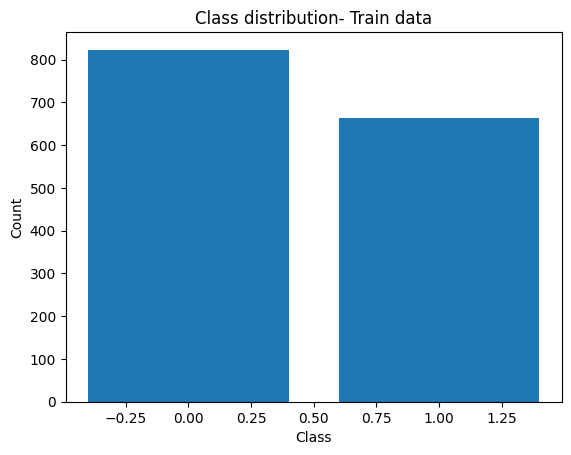

In [30]:
dist_train = np.unique(train.labels, return_counts=True)

plt.bar(dist_train[0], dist_train[1])
plt.title("Class distribution- Train data")
plt.ylabel("Count")
plt.xlabel("Class")

plt.show()

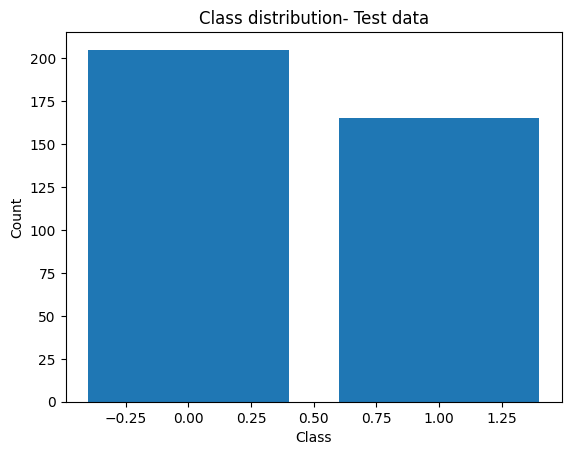

In [31]:
dist_test = np.unique(test.labels, return_counts=True)

plt.bar(dist_test[0], dist_test[1])
plt.title("Class distribution- Test data")
plt.ylabel("Count")
plt.xlabel("Class")

plt.show()

Below, we have analise results of the image augmentation method. Ultimately, we decided to use zooming, slight rotation, and image flipping both vertically and horizontally. The remaining techniques noticeably distorted the image, which could lead to the network's improper functioning.

In [12]:
data_vis = os.path.join(os.getcwd(), "data\\aug_visual")
train_aug, test_aug = data_preparation(data_vis, 0, 1, target_size, normalization=True)

Found 1 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


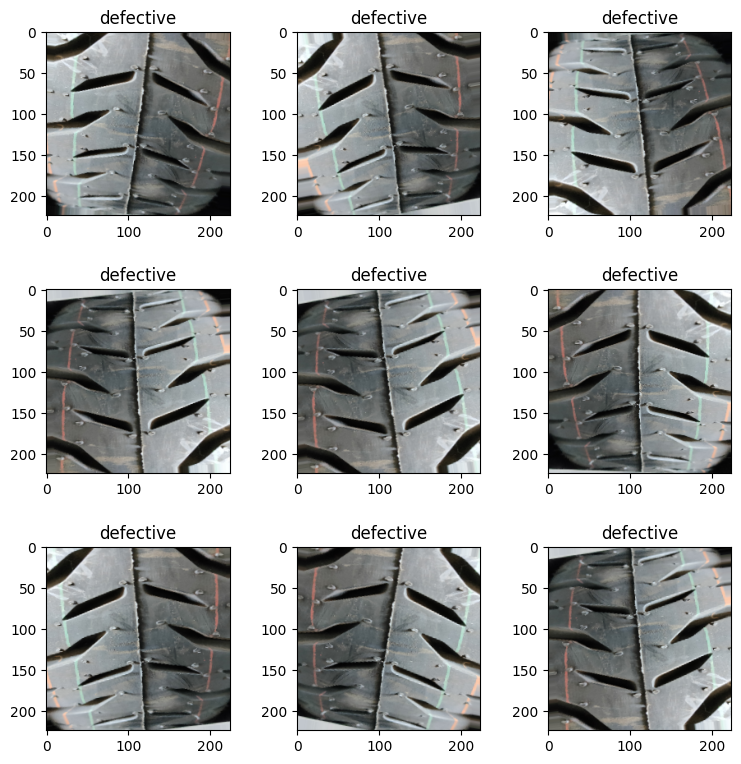

In [13]:
plt.figure(figsize=(8, 8))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.tight_layout(pad=2.0)
    batch = train_aug.next()
    plt.imshow(batch[0][0])    
    
    train_classes = list(train.class_indices.keys())
    plt.title(train_classes[int(batch[1][0])], fontsize=12)

To better understand the dataset, we visualized several example images along with their corresponding classes. It can be observed that the classification of labels created by the author of dataset, is mainly based on the condition/quality of the material from which the tire is made.

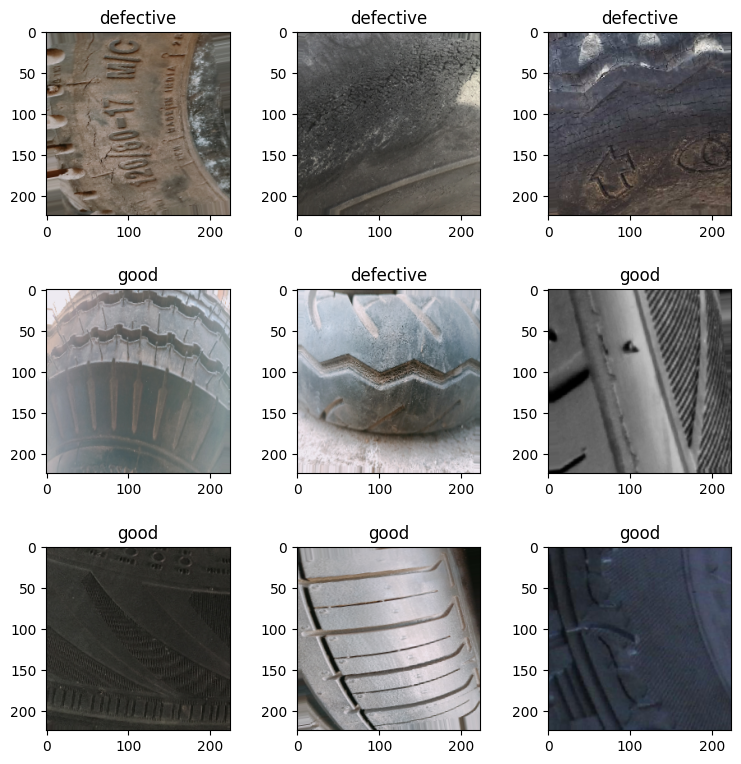

In [22]:
plt.figure(figsize=(8, 8))

batch = train.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.tight_layout(pad=2.0)

    plt.imshow(batch[0][i])
    
    train_classes = list(train.class_indices.keys())
    plt.title(train_classes[int(batch[1][i])], fontsize=12)

## Model training 

### First model- manual architecture

###### Creating architecture and learning the model


The architecture was divided into blocks, with convolutional layers in the blocks, and the final block containing a dense hidden layer. Initial experiments were based on convolutional blocks consisting of only one convolutional layer (Conv2D) and lacked a normalization layer. Ultimately, based on the results, it was observed that increasing the number of convolutional layers within blocks followed by normalization layers significantly improved the model's predictions on the test set. The model's quality also improved by transitioning from one hidden layer to two and increasing the number of neurons. Additionally, the Dropout method was introduced, which also increased accuracy on the test set.

In [34]:
model = Sequential()

# 1 block
model.add(Conv2D(16, 3, input_shape=(target_size[0], target_size[1], 3), padding="same", activation='relu')) #loczba filtrow, kernel size, padding- same (output has the same size as the input)
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(16, 3, padding="same", activation='relu')) 
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D((2,2)))

# 2 block
model.add(Conv2D(32, 3, padding="same", activation='relu')) 
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(32, 3, padding="same", activation='relu')) 
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D((2,2)))

# 3 block
model.add(Conv2D(64, 3, padding="same", activation='relu')) 
model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(64, 3, padding="same", activation='relu')) 
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D((2,2)))

# Final block
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(124, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                        

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
earlystopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    start_from_epoch=20,
    mode="auto"
)

In [39]:
modelcheckpoint = ModelCheckpoint(
    os.path.join(os.getcwd(), "model_save/model/model_1.ckpt"), 
    save_best_only=True, 
    save_weights_only=True,
    verbose=1, 
    monitor='val_loss')

In [40]:
hist_1 = model.fit(
        train, 
        epochs=80,         
        validation_data=test,
        callbacks=[earlystopping,
                   modelcheckpoint],
        verbose=1)

Epoch 1/80
47/47 [==============================] - ETA: 0s - loss: 6.1663 - accuracy: 0.5720
Epoch 1: val_loss improved from inf to 0.94094, saving model to C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model\model_1.ckpt
47/47 [==============================] - 265s 6s/step - loss: 6.1663 - accuracy: 0.5720 - val_loss: 0.9409 - val_accuracy: 0.4514
Epoch 2/80
47/47 [==============================] - ETA: 0s - loss: 2.9777 - accuracy: 0.5734
Epoch 2: val_loss improved from 0.94094 to 0.75559, saving model to C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model\model_1.ckpt
47/47 [==============================] - 264s 6s/step - loss: 2.9777 - accuracy: 0.5734 - val_loss: 0.7556 - val_accuracy: 0.5378
Epoch 3/80
47/47 [==============================] - ETA: 0s - loss: 1.6330 - accuracy: 0.5848
Epoch 3: val_loss did not improve from 0.75559
47/47 [==============================] - 243s 5s/step - loss: 1.6330 - accuracy: 0.5848 - val_loss: 3.9216 - val_accuracy: 0.4459
Epoch

47/47 [==============================] - 232s 5s/step - loss: 0.3228 - accuracy: 0.8681 - val_loss: 2.5263 - val_accuracy: 0.5243
Epoch 30/80
47/47 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8822
Epoch 30: val_loss did not improve from 0.35516
47/47 [==============================] - 232s 5s/step - loss: 0.3042 - accuracy: 0.8822 - val_loss: 0.4726 - val_accuracy: 0.8108


###### Saving model

In [185]:
model.save( os.path.join(os.getcwd(), "model_save/model_manual"))

INFO:tensorflow:Assets written to: C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model_manual\assets


INFO:tensorflow:Assets written to: C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model_manual\assets


###### Model evaluation

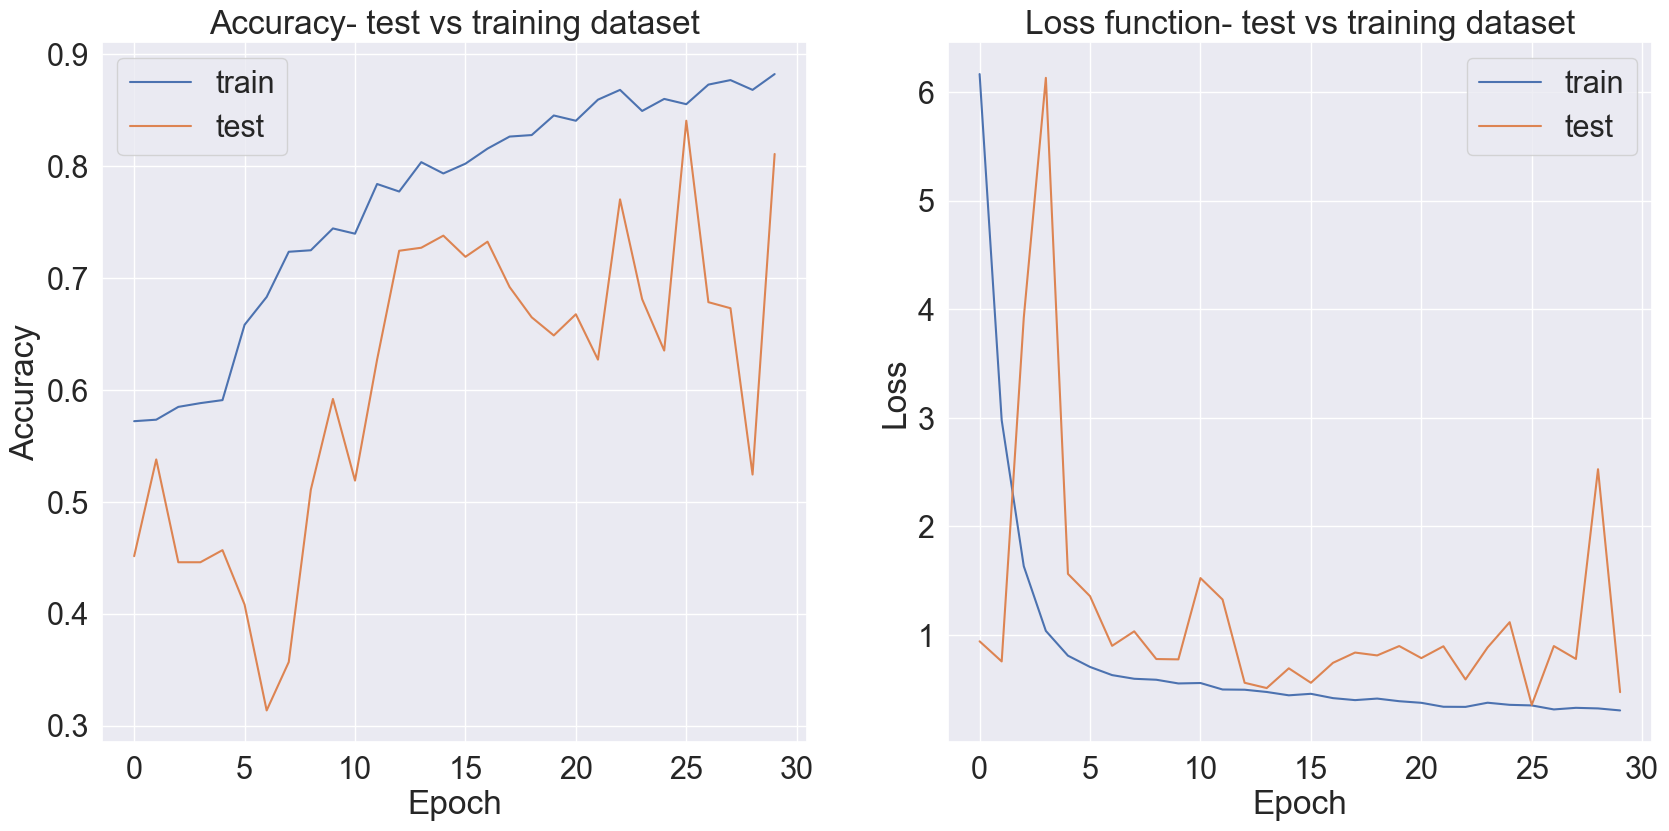

In [188]:
plt.figure( figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Accuracy- test vs training dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

plt.subplot(2, 2, 2)
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Loss function- test vs training dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

plt.show()

Based on the charts, it can be observed that with each epoch, the model achieved progressively better results on the training set. On the test set, we also observed an upward trend, although there are significant fluctuations between epochs. The learning process proceeded in the expected manner, with the model performing better on the training set than on the test set.

Recreating the validation set (without data augmentation)

In [102]:
validation= tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=1234,
    image_size=target_size,
    batch_size=batch_size,
)


Found 1856 files belonging to 2 classes.
Using 371 files for validation.


In [ ]:
# y_pred_3_test = model_3.predict(test, steps= 370//batch_size + 1, verbose = 1)

# y_pred_3_test = y_pred_3_test.round()

# y_true_3_test =test.classes

In [98]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

validation = validation.map(process)

In [103]:
test_images = []
test_labels = []

for image, label in validation:
    test_labels.extend(label.numpy())
    test_images.extend(image.numpy())


In [46]:
y_pred = model.predict(np.array(test_images)).round()

y_true= test_labels

12/12 [==============================] - 9s 753ms/step


In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix

cm = confusion_matrix(y_true, y_pred)

To provide a more detailed assessment of the model, a confusion matrix was generated for the test set, and fundamental metrics such as Accuracy (which can be informative as the classes were balanced), Precision, Recall, and F-1 (a combination of Precision and Recall) were calculated.

Text(47.222222222222214, 0.5, 'True label')

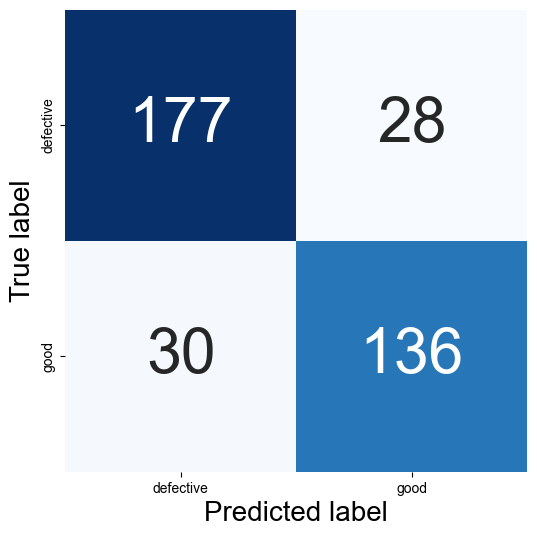

In [48]:
import seaborn as sn

plt.subplots(figsize=(6,6))
sn.set(font_scale=2)
sn.heatmap(cm,cmap="Blues", annot_kws={"size": 45}, square=True, annot=True, fmt='d', cbar=False ,
           yticklabels=['defective', 'good'], xticklabels=['defective', 'good'])#, yticklabels=target_names
plt.xlabel('Predicted label', size=20)
plt.ylabel('True label', size=20)


In [193]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

accuracy_1 = (accuracy_score(y_pred, y_true))
f1_1 = (f1_score(y_pred, y_true, average="macro"))
precision_1 = (precision_score(y_pred, y_true, average="macro"))
recall_1 = (recall_score(y_pred, y_true, average="macro"))


# Print the Results
print(f"Accuracy: {accuracy_1}")
print(f"F1: {f1_1}")
print(f"Precision: {precision_1}")
print(f"Recall: {recall_1}")

Accuracy: 0.8436657681940701
F1: 0.8417328626066489
Precision: 0.8413458712900381
Recall: 0.8421703782255214


The model demonstrates good quality metrics on the test set. For the final model, we relied on the F-1 score. The custom architecture achieved a result of 84% in terms of the F-1 score.

### Second model- VGG19 (transfer learning)

###### Creating architecture and learning the model

For the second model, we utilized transfer learning metod. We implemented a pre-trained architecture of VGG-19 model with pre-trained weights. Only the top layers were custom and trained. During the experiments, the model exhibited the best quality when using two dense layers with 256 and 124 neurons, respectively.

In [50]:
from tensorflow.keras.applications.vgg19 import VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [51]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation="relu"))
top_model.add(Dropout(0.3))
top_model.add(Dense(124, activation="relu"))
top_model.add(Dropout(0.3))
top_model.add(Dense(1, activation="sigmoid"))
top_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 124)               31868     
                                                                 
 dropout_3 (Dropout)         (None, 124)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 125       
                                                                 
Total params: 6454777 (24.62 MB)
Trainable params: 645

In [52]:
model_2 = Sequential()
model_2.add(base_model)
model_2.add(top_model)

base_model.trainable = False

In [53]:
model_2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [55]:
earlystopping_2=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    start_from_epoch=10,
    mode="auto"
)

In [56]:
modelcheckpoint_2 = ModelCheckpoint(
    os.path.join(os.getcwd(), "model_save/model_2/model_2.ckpt"), 
    save_best_only=True, 
    save_weights_only=True,
    verbose=1, 
    monitor='val_loss')

In [58]:
hist_2 = model_2.fit(
        train, 
        epochs=50,         
        validation_data=test,
        callbacks=[earlystopping_2,
                   modelcheckpoint_2],
        verbose=1)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 0.4149 - accuracy: 0.8048 
Epoch 1: val_loss improved from 0.46631 to 0.40032, saving model to C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model_2\model_2.ckpt
47/47 [==============================] - 655s 14s/step - loss: 0.4149 - accuracy: 0.8048 - val_loss: 0.4003 - val_accuracy: 0.8054
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8129 
Epoch 2: val_loss did not improve from 0.40032
47/47 [==============================] - 651s 14s/step - loss: 0.3929 - accuracy: 0.8129 - val_loss: 0.4809 - val_accuracy: 0.7189
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8358 
Epoch 3: val_loss improved from 0.40032 to 0.36289, saving model to C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model_2\model_2.ckpt
47/47 [==============================] - 647s 14s/step - loss: 0.3548 - accuracy: 0.8358 - val_loss: 0.3629 - val_accuracy

47/47 [==============================] - 633s 13s/step - loss: 0.2530 - accuracy: 0.8836 - val_loss: 0.3713 - val_accuracy: 0.8324


###### Saving model

In [189]:
model_2.save( os.path.join(os.getcwd(), "model_save/model_2_manual"))

INFO:tensorflow:Assets written to: C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model_2_manual\assets


INFO:tensorflow:Assets written to: C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model_2_manual\assets


###### Model evaluation

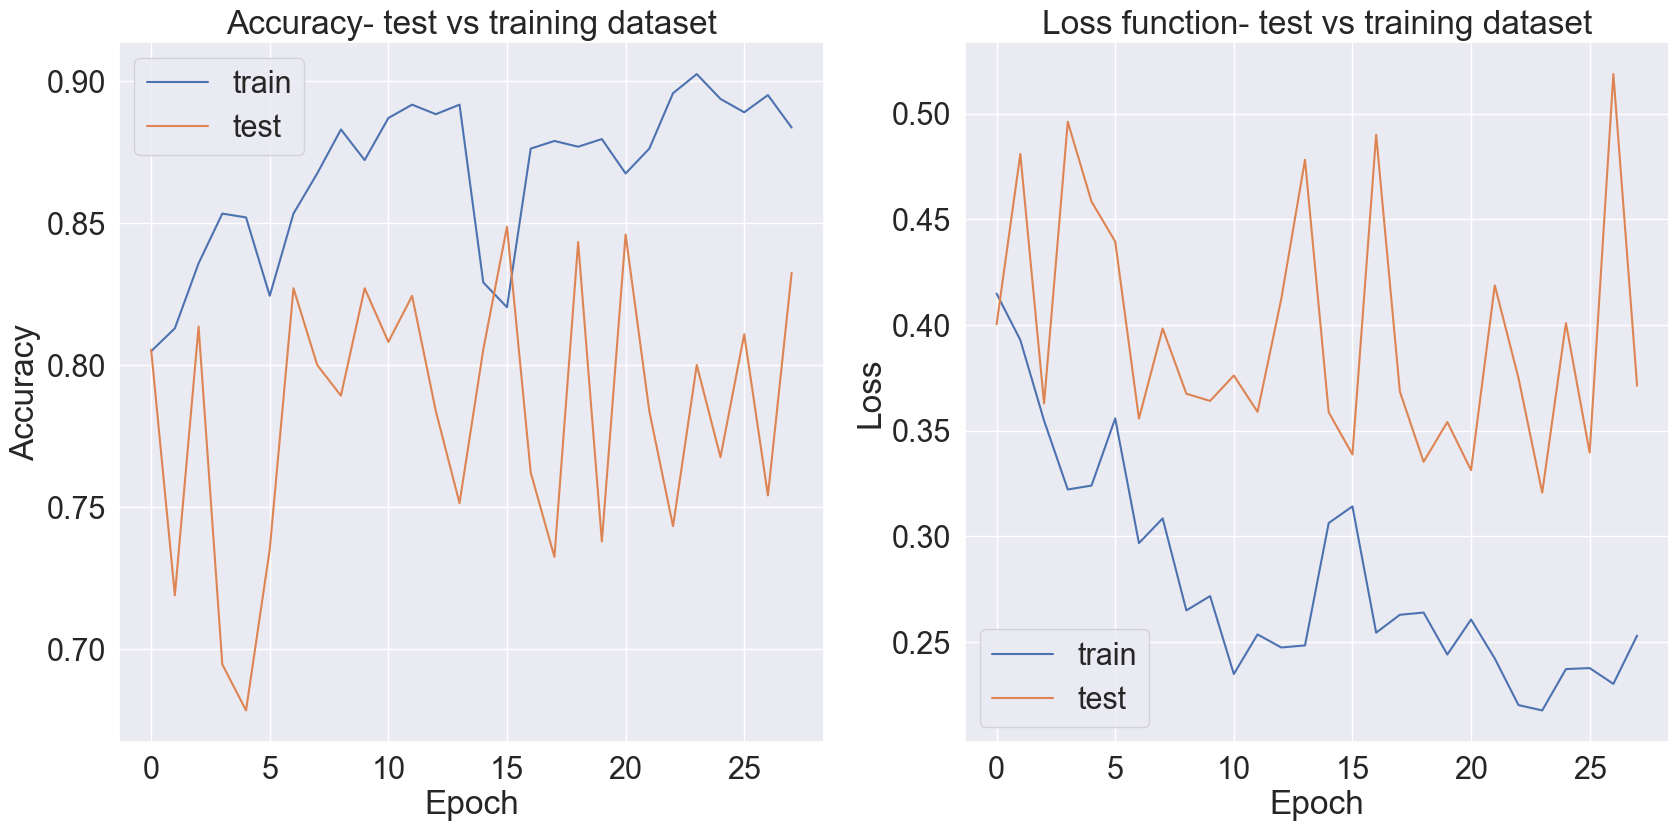

In [190]:
plt.figure( figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Accuracy- test vs training dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

plt.subplot(2, 2, 2)
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Loss function- test vs training dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.show()

In [62]:
y_pred_2 = model_2.predict(np.array(test_images)).round()

y_true_2= test_labels

12/12 [==============================] - 115s 10s/step


Text(28.749999999999993, 0.5, 'True label')

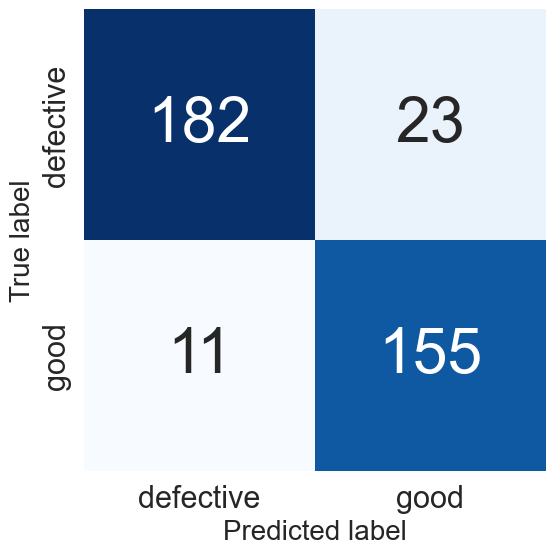

In [63]:
cm = confusion_matrix(y_true_2, y_pred_2)

plt.subplots(figsize=(6,6))
sn.set(font_scale=2)
sn.heatmap(cm,cmap="Blues", annot_kws={"size": 45}, square=True, annot=True, fmt='d', cbar=False ,
           yticklabels=['defective', 'good'], xticklabels=['defective', 'good'])#, yticklabels=target_names
plt.xlabel('Predicted label', size=20)
plt.ylabel('True label', size=20)

In [194]:
accuracy_2 = (accuracy_score(y_pred_2, y_true_2))
f1_2 = (f1_score(y_pred_2, y_true_2, average="macro"))
precision_2 = (precision_score(y_pred_2, y_true_2, average="macro"))
recall_2 = (recall_score(y_pred_2, y_true_2, average="macro"))

# Print the Results
print(f"Accuracy: {accuracy_2}")
print(f"F1: {f1_2}")
print(f"Precision: {precision_2}")
print(f"Recall: {recall_2}")

Accuracy: 0.9083557951482479
F1: 0.9078678275096412
Precision: 0.9107699089039083
Recall: 0.9068958491005414


Based on the confusion matrix and the F-1 score results, Model 2 performs significantly better on the test set than Model 1. The F-1 score increased to 90%. Such a good F-1 score could be anticipated from the confusion matrix, where type I and type II errors significantly decreased.

### Third model- ResNet50 (transfer learning)

###### Creating architecture and learning the model

For the last model, we also utilized the transfer learning technique. This time, we employed the pre-trained ResNet50 architecture and used one dense layer with 512 neurons (decision regarding hidden layers was based on the analysis of other architectures).

In [85]:
(target_size[0], target_size[1], 3)

(224, 224, 3)

In [86]:
from tensorflow.keras.applications.resnet50  import ResNet50

base_model_3 = ResNet50(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
base_model_3.trainable = False
base_model_3.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [87]:
top_model_3 = Sequential()
top_model_3.add(Flatten(input_shape=base_model_3.output_shape[1:]))
top_model_3.add(Dense(512, activation="relu"))
top_model_3.add(Dropout(0.4))
top_model_3.add(Dense(1, activation="sigmoid"))
top_model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                                 
Total params: 51381249 (196.00 MB)
Trainable params: 51381249 (196.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
model_3 = Sequential()
model_3.add(base_model_3)
model_3.add(top_model_3)

model_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 sequential_7 (Sequential)   (None, 1)                 51381249  
                                                                 
Total params: 74968961 (285.98 MB)
Trainable params: 51381249 (196.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [89]:
model_3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [90]:
earlystopping_3=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    start_from_epoch=10,
    mode="auto")

In [91]:
modelcheckpoint_3 = ModelCheckpoint(
    os.path.join(os.getcwd(), "model_save/model_3/model_3.ckpt"), 
    save_best_only=True, 
    save_weights_only=True,
    verbose=1, 
    monitor='val_loss')

In [92]:
hist_3 = model_3.fit(
        train_orig, 
        epochs=50,         
        validation_data=test_orig,
        callbacks=[earlystopping_3,
                   modelcheckpoint_3],
        verbose=1)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 4.9215 - accuracy: 0.8190
Epoch 1: val_loss improved from inf to 1.65339, saving model to C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model_3\model_3.ckpt
47/47 [==============================] - 265s 6s/step - loss: 4.9215 - accuracy: 0.8190 - val_loss: 1.6534 - val_accuracy: 0.8297
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.9273
Epoch 2: val_loss improved from 1.65339 to 0.69546, saving model to C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model_3\model_3.ckpt
47/47 [==============================] - 305s 7s/step - loss: 0.3141 - accuracy: 0.9273 - val_loss: 0.6955 - val_accuracy: 0.8514
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9509
Epoch 3: val_loss did not improve from 0.69546
47/47 [==============================] - 332s 7s/step - loss: 0.1505 - accuracy: 0.9509 - val_loss: 0.8802 - val_accuracy: 0.7865
E

###### Saving model

In [195]:
model_3.save( os.path.join(os.getcwd(), "model_save/model_3_manual"))

INFO:tensorflow:Assets written to: C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model_3_manual\assets


INFO:tensorflow:Assets written to: C:\Users\Eryk\Desktop\DataScience\projekt\model_save/model_3_manual\assets


###### Model evaluation

In [24]:
model_3_test = load_model(os.path.join(os.getcwd(), "model_save/model_3_manual"))

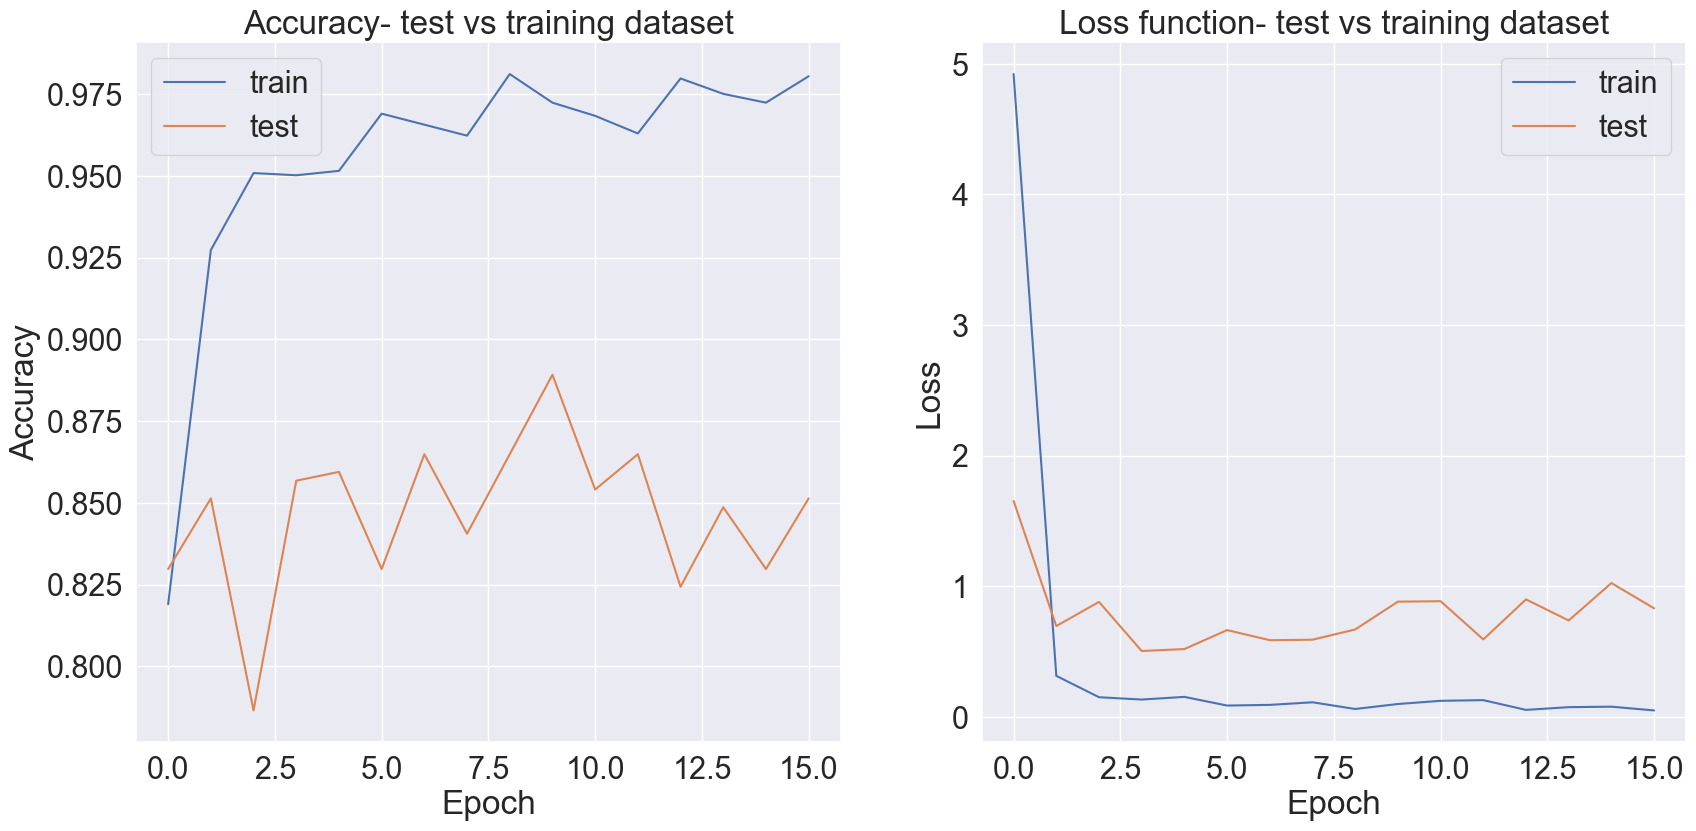

In [196]:
plt.figure( figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.plot(hist_3.history['accuracy'])
plt.plot(hist_3.history['val_accuracy'])
plt.title('Accuracy- test vs training dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

plt.subplot(2, 2, 2)
plt.plot(hist_3.history['loss'])
plt.plot(hist_3.history['val_loss'])
plt.title('Loss function- test vs training dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

plt.show()

In [81]:
test.class_indices

{'defective': 0, 'good': 1}

In [104]:
y_pred_3 = model_3.predict(np.array(test_images)).round()

y_true_3= test_labels

12/12 [==============================] - 51s 4s/step


Text(28.749999999999993, 0.5, 'True label')

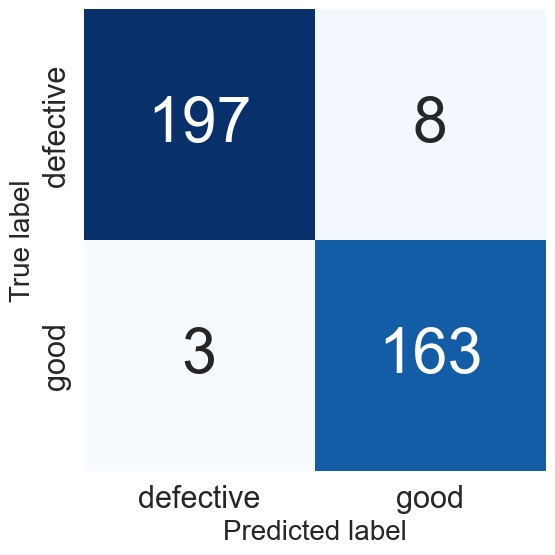

In [105]:
cm = confusion_matrix(y_true_3, y_pred_3)

plt.subplots(figsize=(6,6))
sn.set(font_scale=2)
sn.heatmap(cm,cmap="Blues", annot_kws={"size": 45}, square=True, annot=True, fmt='d', cbar=False ,
           yticklabels=['defective', 'good'], xticklabels=['defective', 'good'])#, yticklabels=target_names
plt.xlabel('Predicted label', size=20)
plt.ylabel('True label', size=20)


In [197]:
accuracy_3 = (accuracy_score(y_pred_3, y_true_3))
f1_3 = (f1_score(y_pred_3, y_true_3))
precision_3 = (precision_score(y_pred_3, y_true_3))
recall_3 = (recall_score(y_pred_3, y_true_3))


# Print the Results
print(f"Accuracy: {accuracy_3}")
print(f"F1: {f1_3}")
print(f"Precision: {precision_3}")
print(f"Recall: {recall_3}")

Accuracy: 0.9703504043126685
F1: 0.9673590504451038
Precision: 0.9819277108433735
Recall: 0.9532163742690059


## Summary

As part of the exercise, three models were investigated: a custom model, VGG19, and ResNet50. To choose the model with the best image classification, the precision and loss function charts of the models on both the training and test sets were reanalyzed.

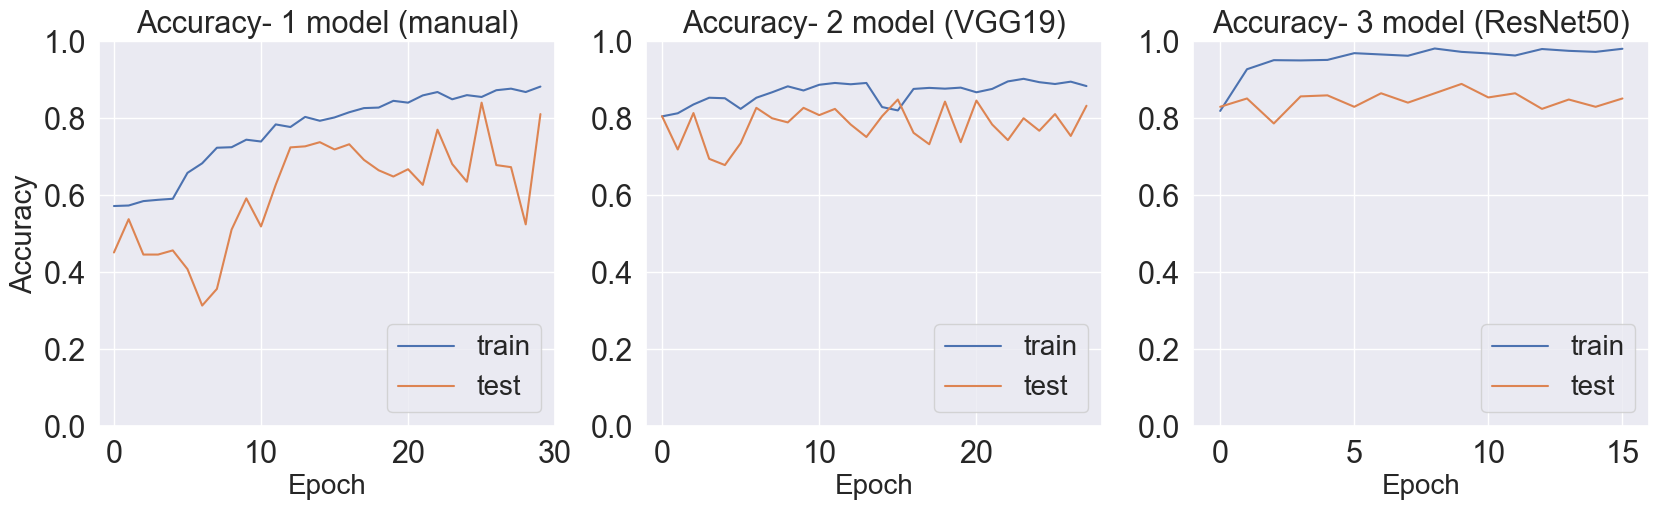

In [199]:
fig = plt.figure(figsize=(20,5))


# Accuracy 1 model
plt.subplot(1, 3, 1)
plt.axis([-1, 30, 0, 1])
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Accuracy- 1 model (manual)', fontsize=22)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy', fontsize=21)
plt.legend(['train', 'test'], loc='lower right', fontsize=20)

# plt.tight_layout(pad=2.0)

# Accuracy 2 model
plt.subplot(1, 3, 2)
plt.axis([-1, 28, 0, 1])
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Accuracy- 2 model (VGG19)', fontsize=22)
plt.xlabel('Epoch', fontsize=20)
# plt.ylabel('Precision')
plt.legend(['train', 'test'], loc='lower right', fontsize=20)

# Accuracy 3 model
plt.subplot(1, 3, 3)
plt.axis([-1, 16, 0, 1])
plt.plot(hist_3.history['accuracy'])
plt.plot(hist_3.history['val_accuracy'])
plt.title('Accuracy- 3 model (ResNet50)', fontsize=22)
plt.xlabel('Epoch', fontsize=20)
# plt.ylabel('Precision')
plt.legend(['train', 'test'], loc='lower right', fontsize=20)

plt.show()


Regarding precision on the test set, two models stand out: VGG19 and ResNet50. The custom architecture performed the worst, so it will not be considered in further analyses.

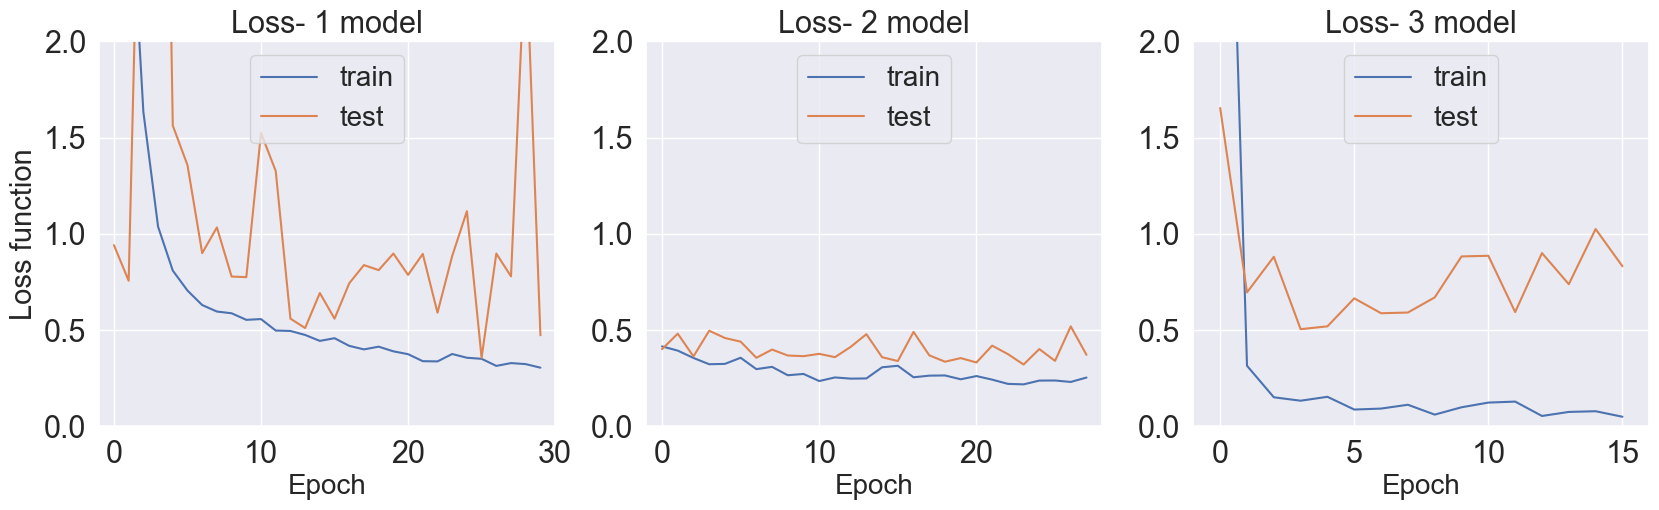

In [183]:
fig = plt.figure(figsize=(20,5))

# Loss 1 model
plt.subplot(1, 3, 1)
plt.axis([-1, 30, 0, 2])
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Loss- 1 model', fontsize=22)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss function', fontsize=21)
plt.legend(['train', 'test'], loc='upper center', fontsize=20)
# plt.tight_layout(pad=2.0)

# Loss 2 model
plt.subplot(1, 3, 2)
plt.axis([-1, 28, 0, 2])
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Loss- 2 model', fontsize=22)
plt.xlabel('Epoch', fontsize=20)
# plt.ylabel('Precision')
plt.legend(['train', 'test'], loc='upper center', fontsize=20)

# Loss 3 model
plt.subplot(1, 3, 3)
plt.axis([-1, 16, 0, 2])
plt.plot(hist_3.history['loss'])
plt.plot(hist_3.history['val_loss'])
plt.title('Loss- 3 model', fontsize=22)
plt.xlabel('Epoch', fontsize=20)
# plt.ylabel('Precision')
plt.legend(['train', 'test'], loc='upper center', fontsize=20)

plt.show()

In terms of the loss function, Model 2 exhibited the best results. Practically, on none of the epochs, we observed a value exceeding 0.5 on the test set.

Quality metrics of the models were also compared on the test set, including accuracy, precision, recall, and F1 score (a combination of precision and recall).

In [200]:
results = pd.DataFrame(data=[[accuracy_1, accuracy_2, accuracy_3],
                             [f1_1, f1_2, f1_3],
                             [precision_1, precision_2, precision_3],
                             [recall_1, recall_2, recall_3]], 
                       index=["accuracy", "f1", "precision", "recall"], 
                       columns=['Mode_1', 'Mode_2', 'Mode_3'])
results

,Mode_1,Mode_2,Mode_3
accuracy,0.843666,0.908356,0.970350
f1,0.841733,0.907868,0.967359
precision,0.841346,0.910770,0.981928
recall,0.842170,0.906896,0.953216


## Summary

Finally, the decision was made to choose Model 2 and Model 3 in further analyses. Although Model 3 had slightly higher values of the loss function than Model 2, it exhibited significantly better classification quality metrics. The accuracy and F-1 score exceeded 96% on the test set. In the next notebook, Model 2 and Model 3 were used to classify images from tire auctions, and based on its results, only offers with good tire quality were selected.